In [7]:
import os
import numpy as np
import scipy
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import rise

In [4]:
os.getcwd()

'C:\\Users\\kathy\\research\\Sea-ice-concentration\\p_pro'

## Method 1: [Pearson Correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [5]:
''' Read and Quickview dataframe'''
# year = '2007'
# year = '2008'
# year = '2013'

# df = pd.read_csv('C:\\Users\\kathy\\research\\Sea-ice-concentration\\data\\LCCA\\time_shift_'+year+'.csv')
df = pd.read_csv('C:\\Users\\kathy\\research\\Sea-ice-concentration\\data\\LCCA\\ALL_LCCA_2002_2019.csv')
df['Date'] = pd.to_datetime(df['Date'])  
df.head()

,Date,Bremen,MERRA-2,NSIDC,OSI-401,OSI-408,ERA5
0,2002-06-01,0.22,0.26,0.18,NaN,NaN,0.0
1,2002-06-02,0.31,0.21,0.14,NaN,NaN,0.0
2,2002-06-03,0.24,0.18,0.20,NaN,NaN,0.0
3,2002-06-04,0.04,0.13,0.14,NaN,NaN,0.0
4,2002-06-05,0.03,0.00,0.00,NaN,NaN,0.0


In [6]:
''' Pearson Correlation Coefficient '''
overall_pearson_r = df.iloc[:,1:].corr()
print(overall_pearson_r)


           Bremen   MERRA-2     NSIDC   OSI-401   OSI-408      ERA5
Bremen   1.000000  0.740838  0.676786  0.709169  0.727201  0.739916
MERRA-2  0.740838  1.000000  0.614128  0.943219  0.808013  0.961523
NSIDC    0.676786  0.614128  1.000000  0.573323  0.370548  0.592543
OSI-401  0.709169  0.943219  0.573323  1.000000  0.837360  0.946937
OSI-408  0.727201  0.808013  0.370548  0.837360  1.000000  0.833459
ERA5     0.739916  0.961523  0.592543  0.946937  0.833459  1.000000


          MERRA-2   OSI-401      ERA5
MERRA-2  1.000000  0.943219  0.961523
OSI-401  0.943219  1.000000  0.946937
ERA5     0.961523  0.946937  1.000000


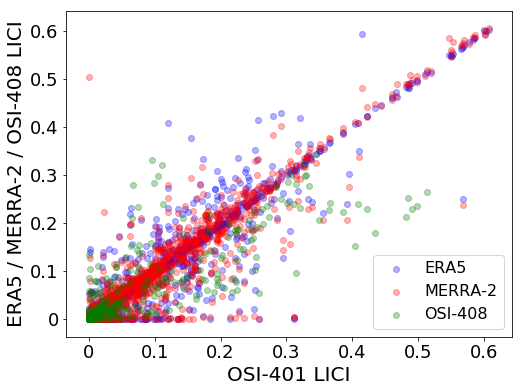

In [6]:
''' Pearson Correlation Coefficient OSI-401/ERA5/MERRA-2 '''
overall_pearson_r = df.iloc[:,[2,4,6]].corr()
print(overall_pearson_r)

f,ax=plt.subplots(figsize=(8,6))
ax.scatter(x=df.iloc[:,4],y=df.iloc[:,6],color='b',alpha=0.3)  # OSI-401 vs ERA5
ax.scatter(x=df.iloc[:,4],y=df.iloc[:,2],color='r',alpha=0.3)  # OSI-401 vs MERRA-2
ax.scatter(x=df.iloc[:,4],y=df.iloc[:,5],color='g',alpha=0.3)  # OSI-401 vs OSI-408


ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=18);
ax.set_xticks([0, 10, 20, 30, 40, 50, 60])
ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=18);


ax.set_xlabel('OSI-401 LICI', fontsize=20);
ax.set_ylabel('ERA5 / MERRA-2 / OSI-408 LICI', fontsize=20)

ax.legend(fontsize=16);
plt.savefig('scatter_plot.png')


## Method 2: [Time Lagged Cross Correlation — assessing signal dynamics](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9)

In [7]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [47]:
''' Choose a year '''
year = np.arange(2002,2020)
i = 17
print(year[i])

start = str(year[i])+'-06-1'
end = str(year[i])+'-10-31'
mask = (df['Date'] > start) & (df['Date'] <= end)
# df.loc[mask]

2019


1.0 1.0


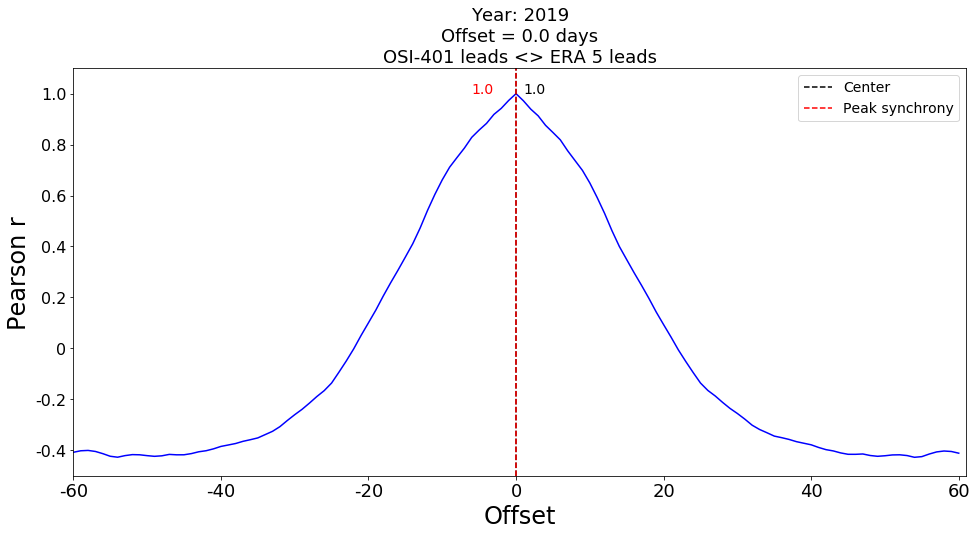

In [48]:
''' Time Lag Correlation for specific yar OSI-401 & ERA5'''

d1 = df.loc[mask,'OSI-401']
d2 = df.loc[mask,'ERA5']

seconds = 1
fps = 60

rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
# offset = np.ceil(len(rs)/2)-np.argmax(rs)   ## The original index is WRONG, use floor instead of ceil.
offset = np.floor(len(rs)/2)-np.argmax(rs)

f,ax=plt.subplots(figsize=(16,7.5))
ax.plot(rs,color='b')
# ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.floor(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')

ax.text(np.argmax(rs)-6,np.max(rs),str(round(np.max(rs),2)),color='r',fontsize=14)
ax.text(np.floor(len(rs)/2)+1,rs[int(np.floor(len(rs)/2))],str(round(rs[int(np.floor(len(rs)/2))],2)),fontsize=14)


ax.set(ylim=[-0.5,1.1],xlim=[0,121])
ax.set_title(f'Year: {year[i]}\nOffset = {offset} days\nOSI-401 leads <> ERA 5 leads',fontsize=18)
ax.set_xlabel('Offset',fontsize=24)
ax.set_ylabel('Pearson r',fontsize=24)
ax.set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=16)
ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
ax.set_xticklabels([-60, -40, -20, 0, 20, 40, 60], fontsize=18);

plt.legend(fontsize=14)
print(round(np.max(rs),2),round(rs[int(np.floor(len(rs)/2))],2))

plt.savefig('time_offset_ERA5_'+str(year[i])+'.png')

0.9965328284778555 0.9965328284778555


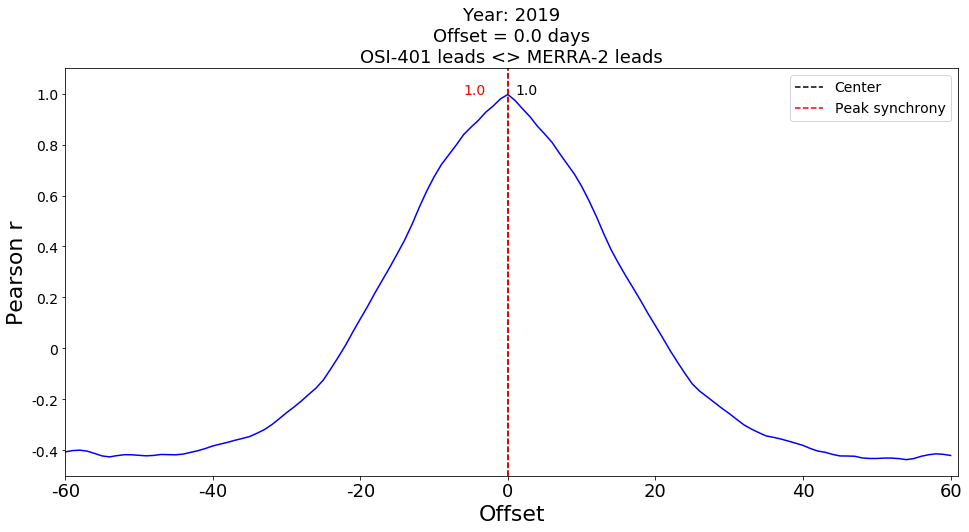

In [49]:
''' Time Lag Correlation for specific year  OSI-401 & MERRA-2'''

d1 = df.loc[mask,'OSI-401']
d2 = df.loc[mask,'MERRA-2']

seconds = 1
fps = 60

rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
# offset = np.ceil(len(rs)/2)-np.argmax(rs)   ## The original index is WRONG, use floor instead of ceil.
offset = np.floor(len(rs)/2)-np.argmax(rs)

f,ax=plt.subplots(figsize=(16,7.5))
ax.plot(rs,color='b')
# ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.floor(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')

ax.text(np.argmax(rs)-6,np.max(rs),str(round(np.max(rs),2)),color='r',fontsize=14)
ax.text(np.floor(len(rs)/2)+1,rs[int(np.floor(len(rs)/2))],str(round(rs[int(np.floor(len(rs)/2))],2)),fontsize=14)

ax.set(ylim=[-0.5,1.1],xlim=[0,121])
ax.set_title(f'Year: {year[i]}\nOffset = {offset} days\nOSI-401 leads <> MERRA-2 leads',fontsize=18)
ax.set_xlabel('Offset',fontsize=22)
ax.set_ylabel('Pearson r',fontsize=22)
ax.set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=14)
ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
ax.set_xticklabels([-60, -40, -20, 0, 20, 40, 60], fontsize=18);


plt.legend(fontsize=14)
print(np.max(rs),rs[int(np.floor(len(rs)/2))])

plt.savefig('time_offset_MERRA2_'+str(year[i])+'.png')

0.6031324975776582 0.11668324937473668


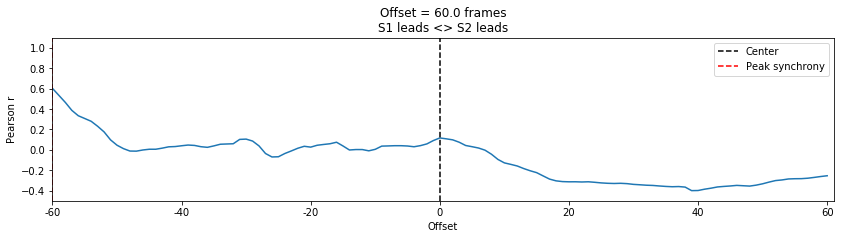

In [300]:
''' Time Lag Correlation for specific year  ERA5 & MERRA-2'''

d1 = df.loc[mask,'ERA5']
d2 = df.loc[mask,'MERRA-2']

seconds = 1
fps = 60

rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
# offset = np.ceil(len(rs)/2)-np.argmax(rs)   ## The original index is WRONG, use floor instead of ceil.
offset = np.floor(len(rs)/2)-np.argmax(rs)

f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
# ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.floor(len(rs)/2),color='k',linestyle='--',label='Center')

ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-.5,1.1],xlim=[0,121], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
ax.set_xticklabels([-60, -40, -20, 0, 20, 40, 60]);

plt.legend()
print(np.max(rs),rs[int(np.floor(len(rs)/2))])